In [ ]:
import os

# Set environment variables for Kaggle API credentials
os.environ["KAGGLE_USERNAME"] = "shrutibansal1211"
os.environ["KAGGLE_KEY"] = "d94bb9323467ea2d1fdfcc599fbc19d4"

# Correct Kaggle download command
!kaggle datasets download angelolmg/tilda-400-64x64-patches

Dataset URL: https://www.kaggle.com/datasets/angelolmg/tilda-400-64x64-patches
License(s): CC-BY-NC-SA-4.0
 92% 131M/142M [00:01<00:00, 82.6MB/s]
100% 142M/142M [00:01<00:00, 77.6MB/s]


In [ ]:
!unzip /content/tilda-400-64x64-patches.zip

Streaming output truncated to the last 5000 lines.
  inflating: good/353_patch7-0.png   
  inflating: good/353_patch7-1.png   
  inflating: good/353_patch7-2.png   
  inflating: good/353_patch7-3.png   
  inflating: good/353_patch7-4.png   
  inflating: good/353_patch7-5.png   
  inflating: good/353_patch7-6.png   
  inflating: good/353_patch7-7.png   
  inflating: good/354_patch0-0.png   
  inflating: good/354_patch0-1.png   
  inflating: good/354_patch0-2.png   
  inflating: good/354_patch0-3.png   
  inflating: good/354_patch0-4.png   
  inflating: good/354_patch0-5.png   
  inflating: good/354_patch0-6.png   
  inflating: good/354_patch0-7.png   
  inflating: good/354_patch1-0.png   
  inflating: good/354_patch1-1.png   
  inflating: good/354_patch1-2.png   
  inflating: good/354_patch1-3.png   
  inflating: good/354_patch1-4.png   
  inflating: good/354_patch1-5.png   
  inflating: good/354_patch1-6.png   
  inflating: good/354_patch1-7.png   
  inflating: good/354_patch2-0.png   

Class: good


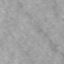


Class: hole


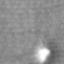


Class: objects


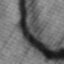


Class: oil spot


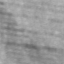


Class: thread error


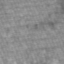

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow
# path
good = '/content/good/000_patch0-3.png'
hole= '/content/hole/002_patch4-5.png'
objects='/content/objects/139_patch1-3.png'
oil_spot='/content/oil spot/047_patch1-2.png'
thread_error='/content/thread error/087_patch3-0.png'

# Reading an image in default mode
for i in range(0,5):
  image_paths = [good, hole, objects, oil_spot, thread_error] # Create a list of actual file paths
  list=['Class: good','Class: hole','Class: objects','Class: oil spot','Class: thread error']
  print(list[i])
  image = cv2.imread(image_paths[i])
  cv2_imshow(image)
  print()

Data visualisation

In [ ]:
def count_images_in_class(class_name):
    class_path = os.path.join('/content/', class_name)
    # List all files in the directory
    if os.path.exists(class_path):
        images = os.listdir(class_path)
        # Filter for image files (you can add more extensions if needed)
        image_files = [f for f in images if f.endswith(('.jpg', '.jpeg', '.png'))]
        return len(image_files)
    else:
        print(f"Class {class_name} does not exist.")
        return 0
l1 = ['good','hole','objects','oil spot','thread error']
for class_name in l1:
    image_count = count_images_in_class(class_name)
    print(f"Number of images in '{class_name}': {image_count}")

Number of images in 'good': 23170
Number of images in 'hole': 337
Number of images in 'objects': 837
Number of images in 'oil spot': 636
Number of images in 'thread error': 620


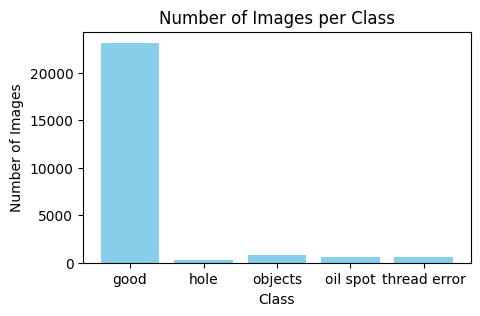

In [ ]:
#bar plot
import matplotlib.pyplot as plt

# Class names and image counts
classes = ['good', 'hole', 'objects', 'oil spot', 'thread error']
image_counts = [23170, 337, 837, 636, 620]

# Create a bar plot
plt.figure(figsize=(5, 3))
plt.bar(classes, image_counts, color='skyblue')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')
plt.show()

Data augmentation

In [ ]:
import numpy as np
from collections import Counter
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
#Subtle augmentations
data_gen = ImageDataGenerator(
    rotation_range=10,  # Small rotation
    width_shift_range=0.1,  # Small horizontal shift
    height_shift_range=0.1,  # Small vertical shift
    zoom_range=0.1,  # Small zoom
    brightness_range=[0.8, 1.2],  # Adjust brightness slightly
    horizontal_flip=True,  # Horizontal flip
    fill_mode='nearest'  # Fill mode for new pixels
)


#Elastic transformations
def elastic_transform(image, alpha, sigma):
    """Applies elastic deformation to an image."""
    random_state = np.random.RandomState(None)
    shape = image.shape
    dx = (random_state.rand(*shape[:2]) * 2 - 1) * alpha
    dy = (random_state.rand(*shape[:2]) * 2 - 1) * alpha
    dz = np.zeros_like(dx)

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = (x + dx).astype(np.float32), (y + dy).astype(np.float32)

    distorted_image = cv2.remap(image, indices[0], indices[1], interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)

    return distorted_image


Number of augmented images generated: 14580

Final class distribution after augmentation:
Class: good, Count: 23170
Class: hole, Count: 2359
Class: objects, Count: 5859
Class: oil spot, Count: 4452
Class: thread error, Count: 4340


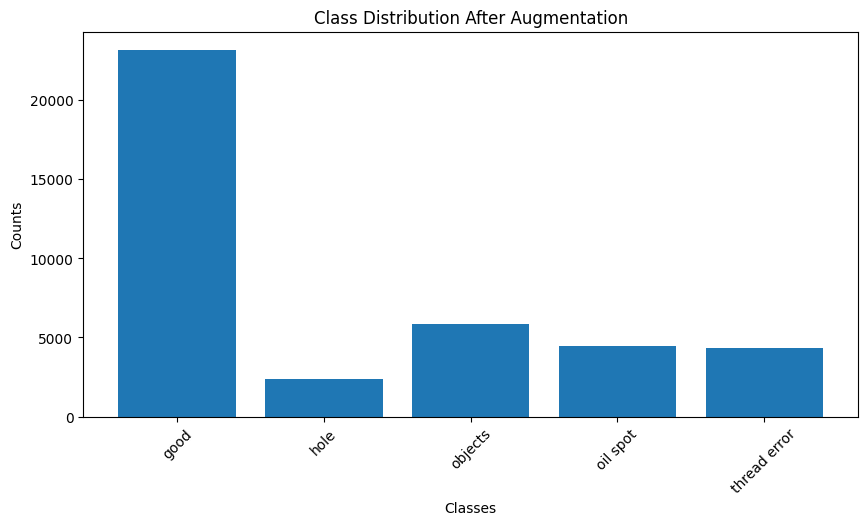

In [ ]:
X = []
y = []

for i in classes:
  for s in os.listdir('/content/'+i):
    path = '/content/'+i+'/'+s
    img = load_img(path, target_size=(64, 64))
    X.append(img_to_array(img))
    y.append(i)



augmented_images = []
augmented_labels = []

for img, label in zip(X, y):
    if label != 'good':
        img = img.reshape((1, 64, 64, 3))

        for _ in range(3):
            augmented_img = data_gen.flow(img, batch_size=1)[0]
            augmented_images.append(augmented_img[0])
            augmented_labels.append(label)

            elastic_image = elastic_transform(augmented_img[0], alpha=5, sigma=1)
            augmented_images.append(elastic_image)
            augmented_labels.append(label)

print(f"\nNumber of augmented images generated: {len(augmented_images)}")

augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)
X_combined = np.concatenate((X, augmented_images), axis=0)
y_combined = np.concatenate((y, augmented_labels), axis=0)

print("\nFinal class distribution after augmentation:")
unique_classes_combined, counts_combined = np.unique(y_combined, return_counts=True)
for cls, count in zip(unique_classes_combined, counts_combined):
    print(f'Class: {cls}, Count: {count}')

def plot_class_distribution(y, title):
    """Visualize the class distribution of the dataset."""
    unique_classes, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(10, 5))
    plt.bar(unique_classes, counts)
    plt.title(title)
    plt.xlabel('Classes')
    plt.ylabel('Counts')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(y_combined, "Class Distribution After Augmentation")

In [ ]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from skimage.filters.rank import entropy
from skimage.morphology import disk
from skimage.filters import threshold_minimum, threshold_otsu
from skimage.util import img_as_ubyte
from skimage.exposure import equalize_hist

In [ ]:
def extract_glcm_features(image, distances=[1], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],levels=64, resize_dim=(32, 32)):
    """
    Extract GLCM features from an image.

    Parameters:
        image (numpy array): Input grayscale image.
        distances (list): Pixel pair distance offsets.
        angles (list): Angles in radians to calculate GLCM.

    Returns:
        features (numpy array): Flattened GLCM features.
    """
    # Ensure the image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Convert the image to uint8 before calculating GLCM
    image = (image / 256 * levels).astype(np.uint8)

    # Compute GLCM
    glcm = graycomatrix(image, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)

    # Extract properties
    contrast = graycoprops(glcm, 'contrast').flatten()
    dissimilarity = graycoprops(glcm, 'dissimilarity').flatten()
    homogeneity = graycoprops(glcm, 'homogeneity').flatten()
    energy = graycoprops(glcm, 'energy').flatten()
    correlation = graycoprops(glcm, 'correlation').flatten()
    asm = graycoprops(glcm, 'ASM').flatten()

    # Combine features
    features = np.hstack([contrast, dissimilarity, homogeneity, energy, correlation, asm])
    return features

def enhance_contrast(image):
    """
    Enhances the contrast of the image using histogram equalization.

    Parameters:
        image (numpy array): Input grayscale image.

    Returns:
        enhanced_image (numpy array): Contrast-enhanced image.
    """
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    enhanced_image = equalize_hist(image)
    return (enhanced_image * 255).astype(np.uint8)

def apply_entropy_filter(image, disk_size=5):
    """
    Applies entropy filter to highlight texture variations.

    Parameters:
        image (numpy array): Input grayscale image.
        disk_size (int): Size of the disk-shaped structuring element.

    Returns:
        filtered_image (numpy array): Image after applying entropy filter.
    """
    # Convert to grayscale if needed
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Ensure the image is in uint8 format
    image = image.astype(np.uint8)

    # Apply entropy filter
    entropy_img = entropy(image, disk(disk_size))
    return entropy_img


def apply_minimum_error_thresholding(image):
    """
    Applies minimum error thresholding to binarize the image.

    Parameters:
        image (numpy array): Input grayscale image.

    Returns:
        thresholded_image (numpy array): Binarized image.
    """
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    try:
        # Try using the minimum error threshold
        threshold_value = threshold_minimum(image)
    except RuntimeError:
        # Fallback to Otsu's method
        print("Warning: Falling back to Otsu's thresholding.")
        threshold_value = threshold_otsu(image)

    # Apply the threshold
    thresholded_image = (image > threshold_value).astype(np.uint8) * 255
    return thresholded_image

In [ ]:
X_glcm = []
y = []

for image, label in zip(X_combined, y_combined):
    entropy_img = apply_entropy_filter(image)
    enhanced_img = enhance_contrast(entropy_img)
    thresholded_img = apply_minimum_error_thresholding(enhanced_img)
    features = extract_glcm_features(thresholded_img)
    X_glcm.append(features)
    y.append(label)

X_glcm = np.array(X_glcm)
y = np.array(y)


In [ ]:
# Use the same indices to split both datasets
train_index, test_index = train_test_split(
    np.arange(len(y_combined)), test_size=0.3, random_state=42, stratify=y_combined)

X_train, X_test = X_combined[train_index], X_combined[test_index]
X_train_glcm, X_test_glcm = X_glcm[train_index], X_glcm[test_index]
y_train, y_test = y_combined[train_index], y_combined[test_index]

label_encoder = LabelEncoder()
y_train_mapped = label_encoder.fit_transform(y_train)
y_test_mapped = label_encoder.transform(y_test)

#With DL

In [ ]:
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# EfficientNet Feature Extractor
def create_combined_model(input_shape=(64, 64, 3), num_classes=5, glcm_feature_size=24):
    cnn_input = Input(shape=input_shape, name="cnn_input")
    base_model = EfficientNetB3(weights="imagenet", include_top=False, input_tensor=cnn_input)
    x = GlobalAveragePooling2D()(base_model.output)

    glcm_input = Input(shape=(glcm_feature_size,), name="glcm_input")

    combined = Concatenate()([x, glcm_input])
    x = Dense(128, activation="relu")(combined)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=[cnn_input, glcm_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

model = create_combined_model()
model.summary()

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cnn_input (InputLayer)    │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 64, 64, 3)      │              0 │ cnn_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 64, 64, 3)      │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 64, 64, 3)      │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 65, 65, 3)      │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 32, 32, 40)     │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 32, 32, 40)     │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 32, 32, 40)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 32, 32, 40)     │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 32, 32, 40)     │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 32, 32, 40)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 10,983,988 (41.90 MB)

 Trainable params: 10,896,685 (41.57 MB)

 Non-trainable params: 87,303 (341.03 KB)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_filepath = 'best_model_glcm_dl.keras'

callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        mode='min',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1,
        restore_best_weights=True
    )
]

history = model.fit(
    {"cnn_input": X_train, "glcm_input": X_train_glcm},
    y_train_mapped,
    validation_data=(
        {"cnn_input": X_test, "glcm_input": X_test_glcm},
        y_test_mapped
    ),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
879/879 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.5708 - loss: 6.3056
Epoch 1: val_loss improved from inf to 0.58978, saving model to best_model_glcm_dl.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 276s 162ms/step - accuracy: 0.5709 - loss: 6.3022 - val_accuracy: 0.7845 - val_loss: 0.5898
Epoch 2/30
878/879 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7692 - loss: 0.6185
Epoch 2: val_loss improved from 0.58978 to 0.46315, saving model to best_model_glcm_dl.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 50s 57ms/step - accuracy: 0.7692 - loss: 0.6184 - val_accuracy: 0.8293 - val_loss: 0.4632
Epoch 3/30
878/879 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8253 - loss: 0.4703
Epoch 3: val_loss improved from 0.46315 to 0.42220, saving model to best_model_glcm_dl.keras
879/879 ━━━━━━━━━━━━━━━━━━━━ 49s 56ms/step - accuracy: 0.8253 - loss: 0.4703 - val_accuracy: 0.8494 - val_loss: 0.4222
Epoch 4/30
878/879 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8538 - loss: 0.3901
Epoch 4: val_loss

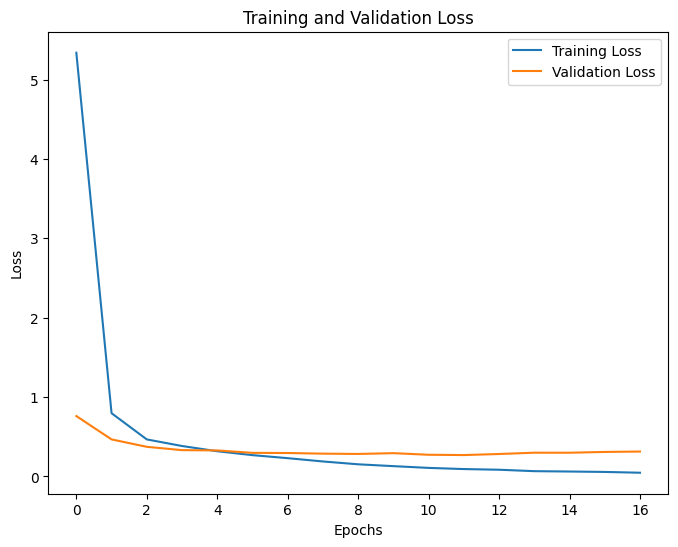

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

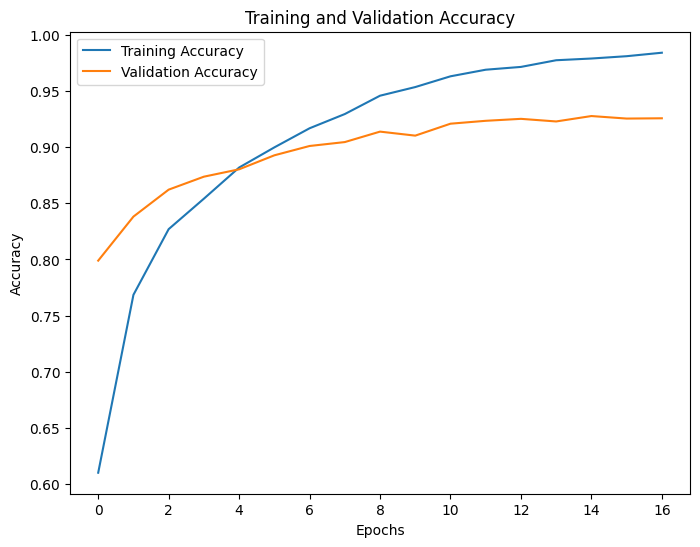

In [ ]:
import matplotlib.pyplot as plt


train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




Test Accuracy: 0.92
377/377 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step
Manual Accuracy: 0.92


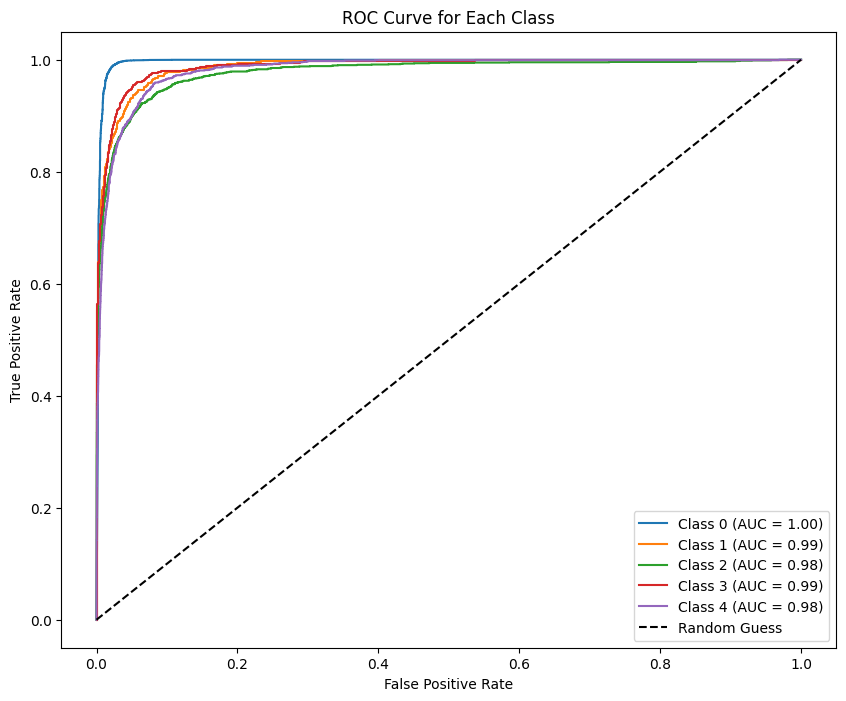

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize


test_loss, test_accuracy = model.evaluate(
    {"cnn_input": X_test, "glcm_input": X_test_glcm},
    y_test_mapped,
    verbose=0
)
print(f"Test Accuracy: {test_accuracy:.2f}")


y_pred_probs = model.predict({"cnn_input": X_test, "glcm_input": X_test_glcm})
y_pred_classes = np.argmax(y_pred_probs, axis=1)

acc = accuracy_score(y_test_mapped, y_pred_classes)
print(f"Manual Accuracy: {acc:.2f}")

y_test_binarized = label_binarize(y_test_mapped, classes=np.arange(len(np.unique(y_test_mapped))))
fpr = {}
tpr = {}
roc_auc = {}
n_classes = y_test_binarized.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Class")
plt.legend(loc="lower right")
plt.show()

#Loading the model

In [ ]:
m = tf.keras.models.load_model('best_model_glcm_dl.keras')
m.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ cnn_input (InputLayer)    │ (None, 64, 64, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 64, 64, 3)      │              0 │ cnn_input[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 64, 64, 3)      │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 64, 64, 3)      │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 65, 65, 3)      │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 32, 32, 40)     │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 32, 32, 40)     │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 32, 32, 40)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 32, 32, 40)     │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 32, 32, 40)     │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 32, 32, 40)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 32,777,360 (125.04 MB)

 Trainable params: 10,896,685 (41.57 MB)

 Non-trainable params: 87,303 (341.03 KB)

 Optimizer params: 21,793,372 (83.14 MB)